In [3]:
from quantum_electron import FullModel, PotentialVisualization, package_versions
from quantum_electron.utils import xy2r, r2xy, density_from_positions, mean_electron_spacing
from quantum_electron.initial_condition import InitialCondition
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me
from alive_progress import alive_bar
import scipy

package_versions()

quantum_electron 0.2.0
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


In this notebook we will study electron density waves in a quasi-1D geometry. The electrons are confined to a long micro-channel. In a separate notebook we simulated the potentials for this geometry using the ZeroHeliumKit module. The FEM data does not need to be generated here but is supplied in the folder fem_data. So, we can now load the results with the `FieldAnalyzer` class. 

NOTE: Please make sure you have installed the `zeroheliumkit` module: https://github.com/eeroqlab/zeroheliumkit

In [4]:
from zeroheliumkit.fem import FieldAnalyzer

In the cell below, we'll define some helper functions for the non-uniform discrete Fourier Transform.

In [5]:
def nufftfreqs(M, df=1):
    """Compute the frequency range used in nufft for M frequency bins"""
    return df * np.arange(-(M // 2), M - (M // 2))

def nudft(x, y, M, df=1.0, iflag=1):
    """Non-Uniform Direct Fourier Transform"""
    sign = -1 if iflag < 0 else 1
    return (1 / len(x)) * np.dot(y, np.exp(sign * 1j * nufftfreqs(M, df) * x[:, np.newaxis]))

def plot_fourier_transforms(electron_positions, eigenfrequencies, eigenvectors):
    # Slow implementation of non-uniform discrete fourier transform
    # Read more at: https://notebook.community/jakevdp/nufftpy/NUFFT-Numba

    xe, ye = r2xy(electron_positions)
    dft_points = 2 * len(eigenfrequencies)
    n_modes = len(eigenfrequencies)
    n_electrons = len(electron_positions) // 2
    fourier_transform = np.zeros((n_modes, dft_points))
    a = mean_electron_spacing(xe, ye)

    with alive_bar(n_modes, force_tty=True) as bar:
        for mode_idx in range(n_modes):
            # The first index is always the cavity amplitude. Here we just want the electron amplitudes
            # The first n are the x amplitudes, the second n are the y amplitudes
            mode_profile_x = eigenvectors.T[mode_idx][1:n_electrons+1]
            mode_profile_y = eigenvectors.T[mode_idx][n_electrons+1:]

            order = np.argsort(xe)
            xdata = xe[order]
            
            # nudft is the non-uniform discrete fourier transform. It samples between 
            A_x = nudft(xdata, mode_profile_x[order], dft_points, df=2 * np.pi / (a * dft_points))
            k_x = nufftfreqs(dft_points, df=2 * np.pi / (a * dft_points))

            fourier_transform[mode_idx, :] = np.abs(A_x)
            bar()
        
    fig = plt.figure(figsize=(7.,4.))
    plt.pcolormesh(k_x * a / np.pi, eigenfrequencies/1e9, 20 * np.log10(fourier_transform), cmap='viridis')

    cbar = plt.colorbar()
    cbar.set_label("FFT Power (dB)")
    plt.ylabel("Frequency $f_e$ (GHz)")
    plt.xlabel("Wavevector $k_x a / \pi$")

# Load the potential data

Let's load the FEM data generated by zeroheliumkit:

In [6]:
phi = FieldAnalyzer(("fem_data/long_channel.txt", 'phi', '2Dmap'))

potential_dict = phi.phi
channel_length = 50
micron = 1e-6

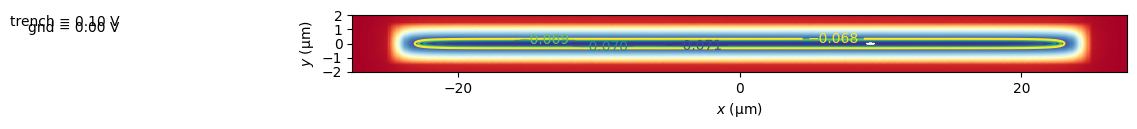

In [7]:
voltages = {"trench" : 0.1, "gnd" : 0.0}

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(ax=ax, dxdy=(55, 4))

Far away from the bottom electrode, the potential always looks parabolic. Let's take a slice to get a sense of the curvature of the electrostatic potential. We do this by fitting the potential energy to a quadratic function $y = a x^2 + b x + c$. The quadratic coefficient contains the curvature.

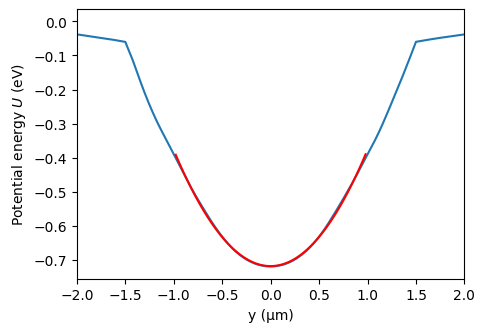

In [8]:
potential_slice = -potential_dict['trench'][500, :]

fig = plt.figure(figsize=(5, 3.5))
plt.plot(potential_dict['ylist'], potential_slice)
plt.xlim(-2, 2)
plt.xlabel(f"y ({chr(956)}m)")
plt.ylabel("Potential energy $U$ (eV)")

def quadratic_func(x, *p):
    a, b, c = p
    return a*x**2 + b*x + c

fitdomain = (-1, 1) # microns
selection = np.where((potential_dict['ylist'] > fitdomain[0]) & (potential_dict['ylist'] < fitdomain[-1]))[0]
xdata = potential_dict['ylist'][selection]
ydata = potential_slice[selection]

popt, pcov = scipy.optimize.curve_fit(quadratic_func, xdata, ydata, p0=(1, 1, 1))

plt.plot(xdata, quadratic_func(xdata, *popt), '-r')

# Note, this is the quadratic coefficient with 1V applied to the trench
quadratic_coefficient = popt[0] / micron ** 2

# Adding electrons

We may now add our first electrons. 

387


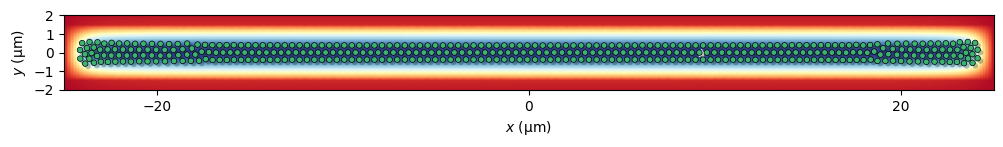

In [11]:
n_electrons = 400

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, 
               max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
ic = InitialCondition(potential_dict, voltages)
initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(channel_length - 3, 1.6), n_rows=4)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

# Plot the results
fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

# How many electrons are left:
print(len(final_x))

In [12]:
density_from_positions(final_x, final_y) / 1e13

0.8279234640184207

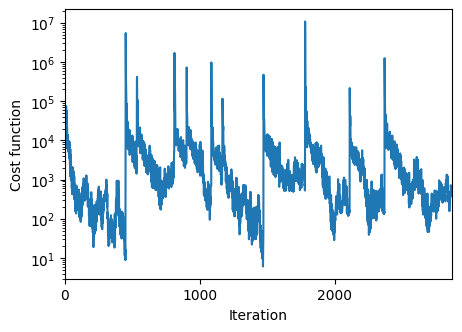

In [13]:
fm.plot_convergence()

Zoom in to see wheter there are dislocations in the crystal structure

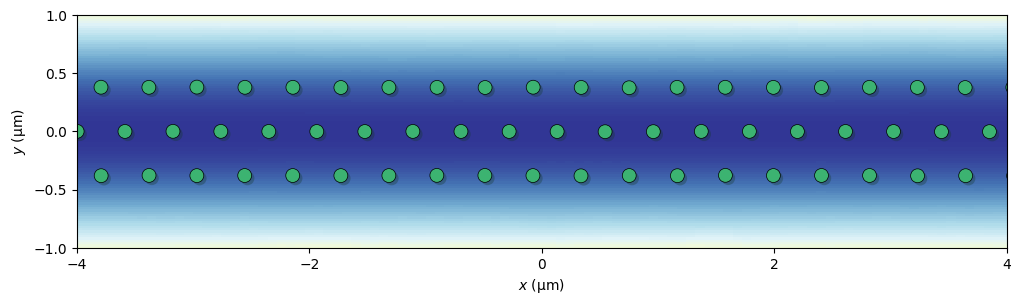

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

# Eigenmodes of a 1D-chain

In this section we study the eigenmodes of a one-dimensional chain. The characteristic frequency is given by $\omega_\mathrm{Coulomb}$, which is we will quickly derive below. Consider a chain of electrons whose restoring force is only given by the electron-electron interaction. We may start by  linearizing the force around the electron equilibrium positions: 

$$
F \approx F (r = r_0) + \frac{\partial F}{\partial r} (r = r_0) \, \delta r
$$

For electrons that experience the Coulomb force, we know $F = \frac{e^2}{4\pi \varepsilon_0 r^2}$. Therefore, we can write 

$$
F \approx \frac{e^2}{4\pi \varepsilon_0 r^3} (r = a) \delta r = k_e \delta r
$$
where we identify the "spring constant" $k_e = \frac{e^2}{4\pi \varepsilon_0 a^3}$ and $a$ is the electron spacing. The characteristic frequency is now simply

$$
\omega_\mathrm{Coulomb}^2 = \frac{4 k_e}{m_e} = \frac{4 e^2}{4\pi \varepsilon_0 a^3}
$$

The other characteristic frequency is the cross-channel potential curvature given by $\omega_\perp$:

In [15]:
print("Trap curvature for electrons is", 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * quadratic_coefficient * voltages['trench'] / me), "GHz")

Trap curvature for electrons is 17.417221585763265 GHz


For up to 100 electrons we can have a single row of electrons.

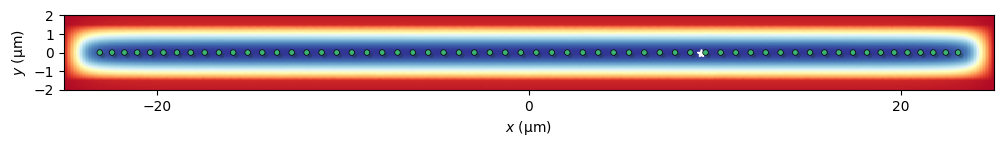

In [16]:
n_electrons = 60 #30
n_plots = 5

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*5, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
ic = InitialCondition(potential_dict, voltages)
initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(channel_length - 3, 1.6), n_rows=1)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

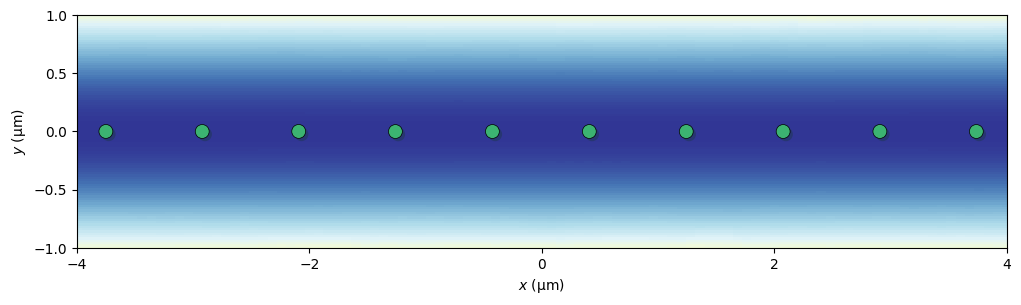

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

Let's take a look at the eigenvectors in a cool animation. We see that there are longitudonal modes that appear:

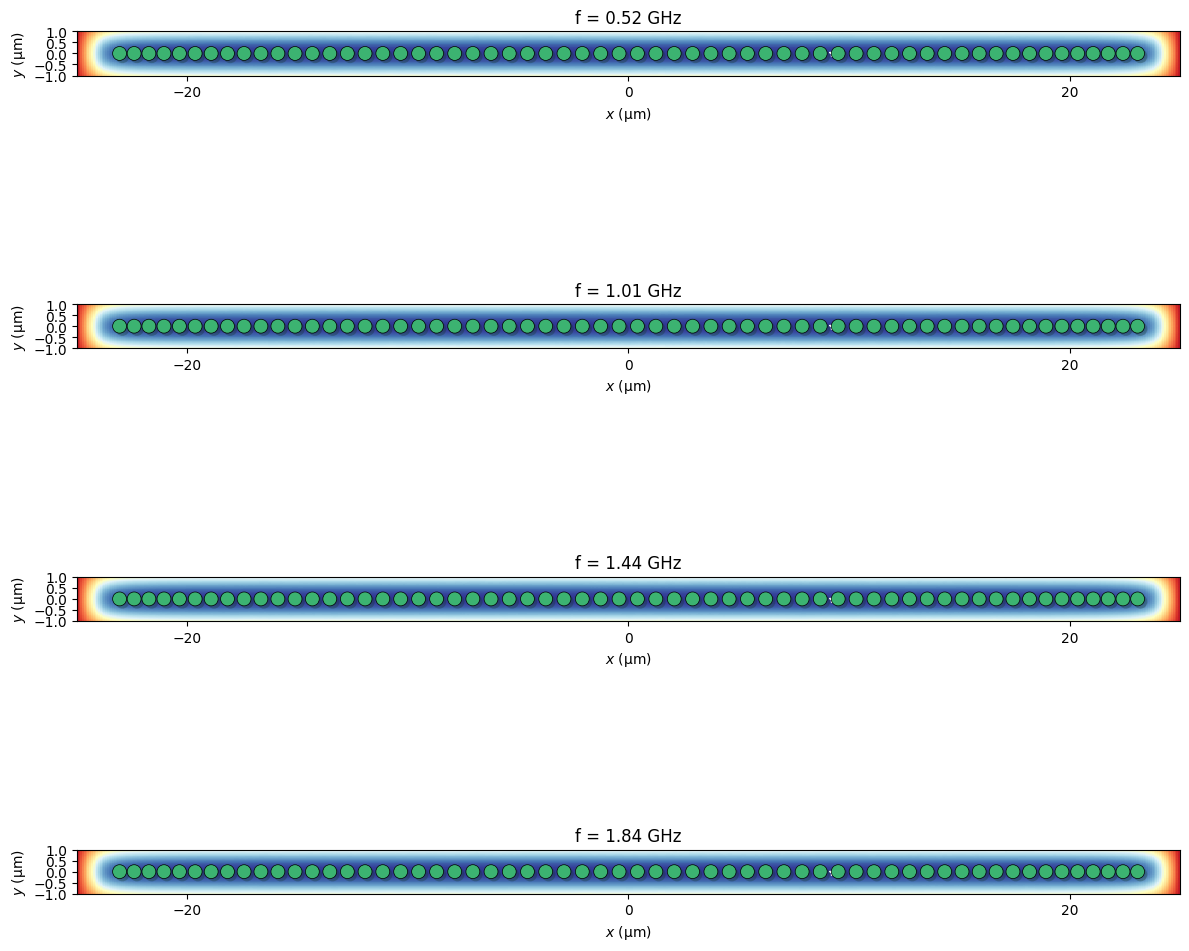

In [18]:
n_plots = 4

resonator_dict = {"f0" : 4e9, 
                  "Z0" : 50.0}

fig, ax = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots))
fm.set_rf_interpolator(rf_electrode_labels=['trench'])

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'], resonator_dict=resonator_dict)
    efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=False)

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    
fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'])

In [19]:
fm.show_animation(anim)

## Extracting the dispersion relation

To compare the mode frequencies with the theory estimates (and characteristic frequencies mentioned above), we're reconstructing the dispersion relation here. We do this by looking at the eigenmodes and fitting the electron $x$-amplitudes to the following mode profile:

$$
A(x) = A_0 \sin \left( \frac{n \pi (x - L/2)}{L} \right)
$$

The wave vector $k$ is $n \pi / L$ and $n$ is an integer. Note: this fitting procedure works for the longitudonal modes, not for transverse modes.

/Users/gkoolstra/anaconda3/envs/zhk/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


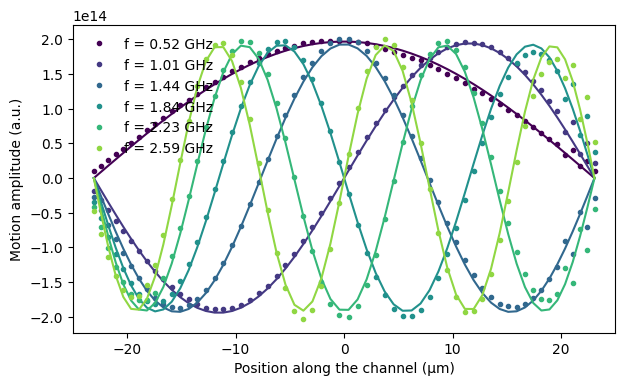

In [20]:
m = len(final_x)
chain_length = np.max(final_x) - np.min(final_x)
a = mean_electron_spacing(final_x, final_y)

max_plots = 6
max_modes = m-5
fitparams = np.zeros((max_modes, 2))
mean_amplitudes = np.zeros((max_modes, 2))

fig = plt.figure(figsize=(7, 4.))
for mode_idx in range(max_modes):
    mode_profile = evecs.T[mode_idx][1:m+1]

    def sine_func(x, *p):
        A, n = p
        return A * np.sin(np.round(n) * np.pi * (x - chain_length/2) / chain_length)

    order = np.argsort(final_x)
    xdata = final_x[order]
    ydata = mode_profile[order]

    popt, pcov = scipy.optimize.curve_fit(sine_func, xdata, ydata, p0=(np.max(ydata), mode_idx+1))

    if mode_idx < max_plots:
        plt.plot(xdata / micron, ydata, '.', color=plt.cm.viridis(mode_idx / max_plots), label=f"f = {efreqs[mode_idx]/1e9:.2f} GHz")
        plt.plot(xdata / micron, sine_func(xdata, *popt), '-', color=plt.cm.viridis(mode_idx / max_plots))

    fitparams[mode_idx, :] = popt
    mean_amplitudes[mode_idx, 0] = np.mean(np.abs(evecs.T[mode_idx][1:m+1])) # Avergage x-amplitudes
    mean_amplitudes[mode_idx, 1] = np.mean(np.abs(evecs.T[mode_idx][m+1:])) # Average y-amplitudes
        
plus_minus = np.sign(fitparams[:, 0])
wave_vectors = plus_minus * fitparams[:, 1] * np.pi / chain_length

plt.xlim(-channel_length/2, channel_length/2)
plt.xlabel(f"Position along the channel ({chr(956)}m)")
plt.ylabel("Motion amplitude (a.u.)")
plt.legend(loc=0, frameon=False)

Now we've determined the wave vectors, we can reconstruct the dispersion relation. Furthermore, we can compare this with the theory from the following papers: 
- Eq. (11) in https://journals.aps.org/prb/abstract/10.1103/PhysRevB.77.064111 
- Eq. (2a) in http://jetpletters.ru/ps/1344/article_20292.pdf 
- https://doi.org/10.1063/10.0001909

(-1.0, 1.0)

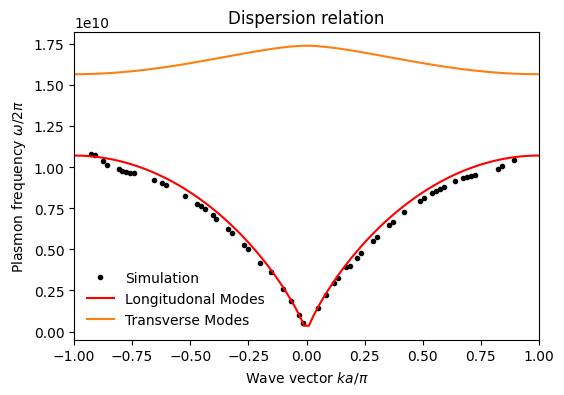

In [21]:
fig = plt.figure(figsize=(6., 4.))

plt.plot(wave_vectors * a / np.pi, efreqs[:len(wave_vectors)], '.k', label="Simulation")

kk = np.arange(1, m)
q_plot = np.linspace(-np.pi/a, np.pi/a, 100)

# Calculate the longitudinal mode frequencies
omega_coulomb = np.sqrt(4 * qe ** 2 / (4 * np.pi * eps0 * me * a ** 3))

# Calculate the transverse mode frequencies
omega_par = np.array([np.sqrt(omega_coulomb ** 2 * np.sum((1 - np.cos(kk * q * a)) / kk ** 3)) / (2 * np.pi) for q in q_plot])
trap_curvature = 1 / (2 * np.pi) * np.sqrt(2 * qe * voltages['trench'] * quadratic_coefficient / me)
omega_perp = np.sqrt(trap_curvature ** 2 - 0.5 * omega_par ** 2)

plt.plot(q_plot * a / np.pi, omega_par, '-r', label="Longitudonal Modes")
plt.plot(q_plot * a / np.pi, omega_perp, '-', color='tab:orange', label="Transverse Modes")

plt.legend(loc=0, frameon=False)
plt.title("Dispersion relation")
plt.xlabel("Wave vector $k a / π$")
plt.ylabel("Plasmon frequency $ω / 2\pi$")
plt.xlim(-1, 1)

We can also take the fourier transform of the amplitudes, which gives is the wave vectors $k_x$. Again we see pretty good agreement for the longitudonal modes. Also note the dark line at the cavity frequency that we supplied in the `resonator_dict`

|                                        | ▁▃▅ 0/121 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 121/121 [100%] in 0.4s (338.46/s)    


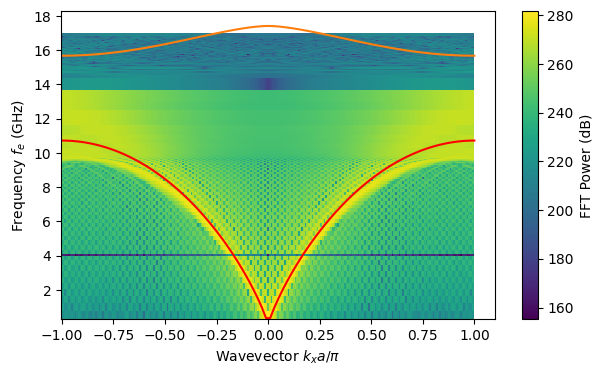

In [22]:
plot_fourier_transforms(res['x'], efreqs, evecs)
plt.plot(q_plot * a / np.pi, omega_par/1e9, '-r', label="Longitudonal Modes")
plt.plot(q_plot * a / np.pi, omega_perp/1e9, '-', color='tab:orange', label="Transverse Modes")

As stated, we expect good agreement for longitudonal modes. For low electron densities, the longitudonal and transverse modes are well separated. Here we can see the relevant frequencies for each mode type more easily:

(0.0, 4.2)

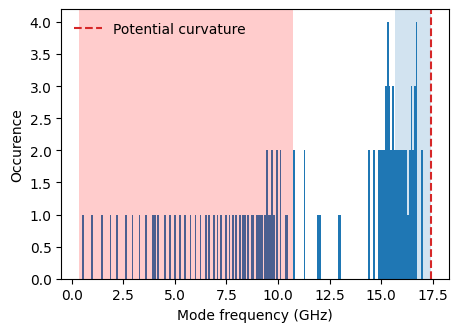

In [23]:
fig = plt.figure(figsize=(5., 3.5))
plt.hist(efreqs/1e9, bins=200)
plt.axvline(trap_curvature/1e9, linestyle='--', color='tab:red', label="Potential curvature")
plt.xlabel("Mode frequency (GHz)")
plt.ylabel("Occurence")
plt.legend(loc=0, frameon=False)

ymin, ymax = plt.ylim()
alpha = 0.2

# Shaded regions indicate where we should expect longitudinal and transverse modes
plt.fill_between(x=[np.min(omega_par)/1e9, np.max(omega_par)/1e9], 
                 y1=ymin, y2=ymax, color='r', alpha=alpha, lw=0)

plt.fill_between(x=[np.min(omega_perp)/1e9, np.max(omega_perp)/1e9], 
                 y1=ymin, y2=ymax, color='tab:blue', alpha=alpha, lw=0)

plt.ylim(ymin, ymax)

Small differences from the theory dispersion relation can also be expected if the electron spacing is not uniform. Let's verify the homogeneity along the channel:

Text(0.5, 1.0, 'Density along the channel')

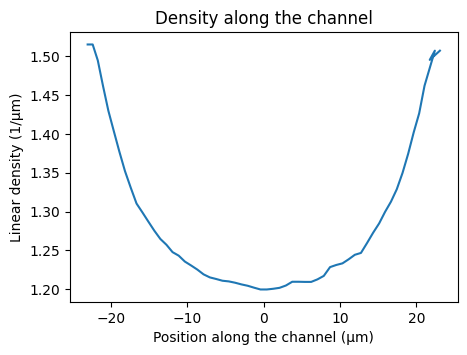

In [24]:
XiXj, YiYj, rij = fm.calculate_metrics(final_x, final_y)
np.fill_diagonal(rij, np.inf)

fig = plt.figure(figsize=(5.,3.5))
plt.plot(final_x / micron, 1 / (np.min(rij, axis=0) / micron))
plt.ylabel("Linear density (1/μm)")
plt.xlabel("Position along the channel (μm)")
plt.title("Density along the channel")

## Density dependence of the dispersion relation

In [81]:
n_sweep = np.arange(10, 140, 2)
n_modes = 1
plot_configuration = False

linear_density = []
electron_frequencies = np.zeros((len(n_sweep), n_modes))

with alive_bar(len(n_sweep), force_tty=True) as bar:
    for k, n_electrons in enumerate(n_sweep):
        if plot_configuration:
            fig, ax = plt.subplots(1, 1, figsize=(12, 4))

        fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*5, 
                       max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
        fm.remove_unbound_electrons = True

        # Create a rectangular initial condition
        ic = InitialCondition(potential_dict, voltages)
        initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(channel_length - 3, 1.6), n_rows=1)

        # Feed this into the model
        res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
        final_x, final_y = r2xy(res['x'])

        if plot_configuration:
            fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
            fm.plot_electron_positions(res, ax=ax, marker_size=4)

        # Feed this into the model
        res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

        # Solve the equations of motion
        fm.set_rf_interpolator(rf_electrode_labels=['trench'])
        K, M = fm.setup_eom(res['x'], resonator_dict=resonator_dict)
        efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=False)

        if plot_configuration:
            ax.set_title(f"f = {efreqs[0]/1e9:.2f} GHz")

        linear_density.append(1 / mean_electron_spacing(final_x, final_y))
        electron_frequencies[k, :] = efreqs[:n_modes]

        bar()

linear_density = np.array(linear_density)

on 58: /Users/gkoolstra/Documents/Code/quantum_electron/quantum_electron/eom_solver.py:278: RuntimeWarning: invalid value encountered in sqrt
         return np.sqrt(EVals) / (2 * np.pi), EVecs


|████████████████████████████████████████| 65/65 [100%] in 2:54.5 (0.37/s)      


To compare the density dependence to the theory, we can start from the dispersion relation for the longitudonal mode:
$$ 
\omega^2 = \omega_\mathrm{Coulomb}^2 \sum_{k = 1}^N  \frac{1 - \cos(k q a)}{k^3} \sim \omega_\mathrm{Coulomb}^2  (qa)^2
$$
where $a$ is the mean distance between neighboring electrons. This formula holds in the regime $qa \ll 1$. Now note that $\omega_\mathrm{Coulomb}^2 \sim a^{-3}$ and so we find 
$$ 
\omega^2 \sim \frac{a^2}{a^3} = 1/a = \lambda.
$$
and $\lambda$ is the linear density. The blue line below shows there is pretty good agreement for moderate linear densities. For the lowest linear densities the approximation $qa \ll 1$ starts to break down, so we should expect the agreement to be worse there.

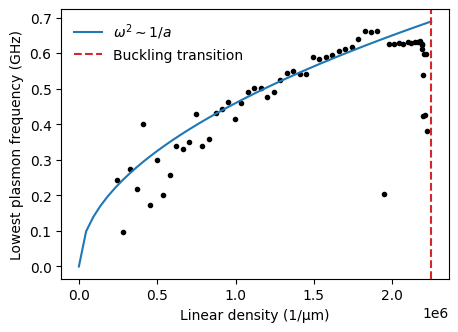

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

plt.plot(linear_density, electron_frequencies[:, 0] / 1e9, '.k')

# Calculate the buckling density (the transition from 1->2 rows)
gamma = 2.08
n_12 = (4 * np.pi * eps0 * voltages['trench'] * quadratic_coefficient / (gamma * qe)) ** (1/3)

# Plot the density dependence expected from theory
lambda_plot = np.linspace(0, n_12)
plt.plot(lambda_plot, 0.65 * (lambda_plot  / 2e6) ** (0.5), label=r"$\omega^2 \sim 1/a$")

plt.axvline(n_12, linestyle='--', color='tab:red', label="Buckling transition")
plt.xlabel("Linear density (1/μm)")
plt.ylabel("Lowest plasmon frequency (GHz)")
plt.legend(loc=0, frameon=False)

In addition, near the 1 to 2 row transition, a sudden drop in frequency can be observed. The transition from 1 to 2 rows isn't instantaneous and at first only part of the chain transitions into 2 rows, whereas part of the chain remains in a single row. The formation of the second row decreases the density along the rest of the chain and thus a drop in frequency.

# Eigenmodes of a multi-row system

With the intuition developed in the previous sections, we'll now study the more complicated behavior that appears at higher electron densities.

Channel holds 450 electrons


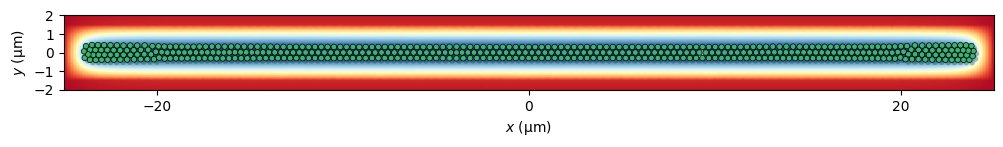

In [135]:
voltages = {"trench" : 0.2, "gnd" : 0.0}

n_electrons = 450
n_plots = 5

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*5, 
               max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
ic = InitialCondition(potential_dict, voltages)
initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(channel_length - 3, 1.6), n_rows=5)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

# Plot the results
fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

print(f"Channel holds {len(final_x)} electrons")

In general, with more electrons the densities and thus mode frequencies increase compared with only a single row of electrons

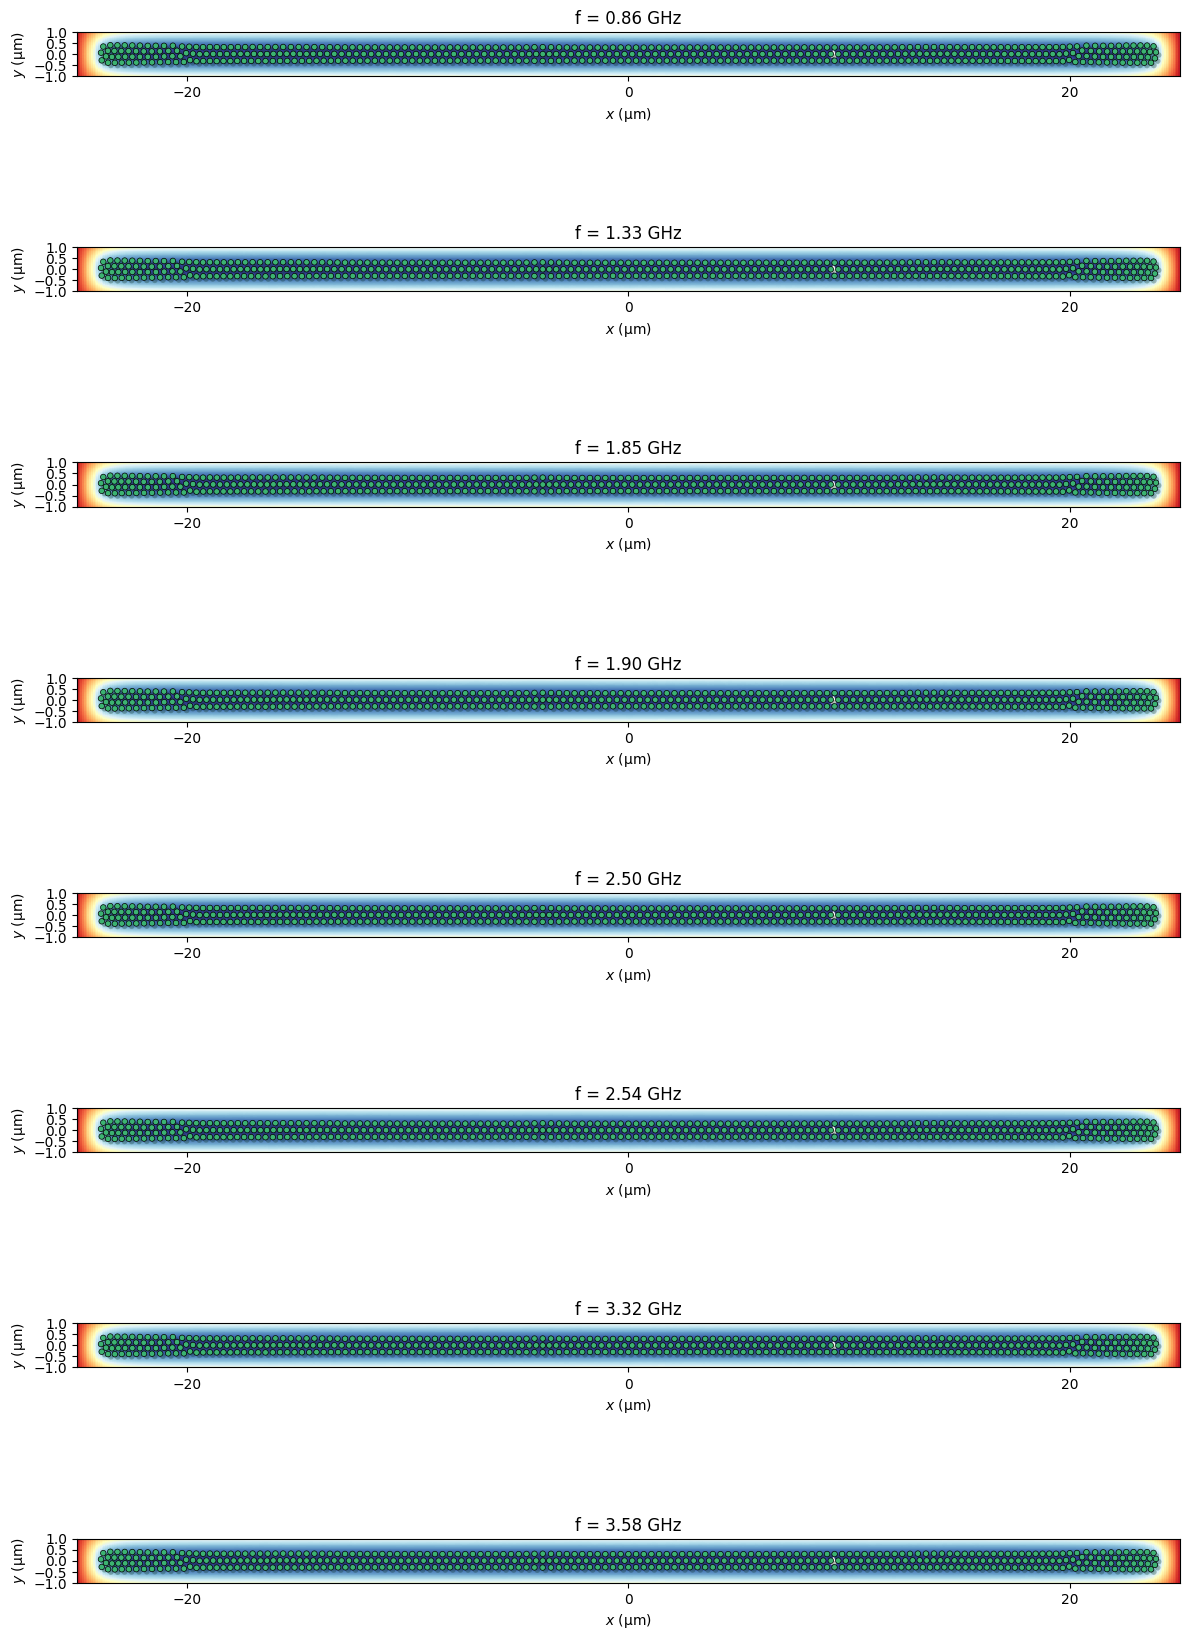

In [136]:
n_plots = 8

fig, ax = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots))
fm.set_rf_interpolator(rf_electrode_labels=['trench'])

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)
    # fm.plot_electron_positions(res, ax=ax[n])

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'], resonator_dict=resonator_dict)
    efreqs, evecs = fm.solve_eom(K, M, filter_nan=True, sort_by_cavity_participation=False)

    # fm.plot_eigenvector(res['x'], evecs[:, n])

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    # fm.plot_electron_positions(res, ax=ax[n], marker_size=4)

plt.subplots_adjust(hspace=-0.8)
fig.tight_layout()

anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'], marker_size=4)

In [137]:
fm.show_animation(anim)

If we look at the amplitude of the lowest frequency modes, they are still mostly longitudonal modes with electron motion mostly along the channel (in the $x$-direction). The ends also show some deviation, which implies some mixing of the transverse and longitudonal modes.

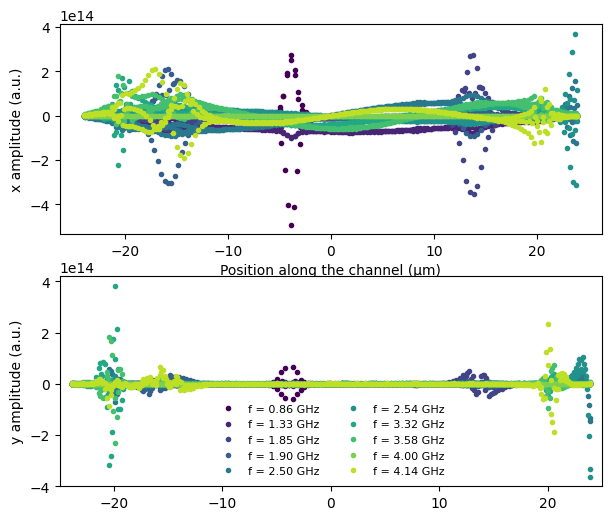

In [138]:
max_plots = 10
max_modes = 10
fitparams = np.zeros((max_modes, 2))
mean_amplitudes = np.zeros((max_modes, 2))
m = len(final_x)

fig, ax = plt.subplots(2, 1, figsize=(7, 6.))
for mode_idx in range(max_modes):
    mode_profile_x = evecs.T[mode_idx][1:m+1]
    mode_profile_y = evecs.T[mode_idx][m+1:]

    order = np.argsort(final_x)
    xdata = final_x[order]

    if mode_idx < max_plots:
        ax[0].plot(xdata / micron, mode_profile_x[order], '.', color=plt.cm.viridis(mode_idx / max_plots), label=f"f = {efreqs[mode_idx]/1e9:.2f} GHz")

        ax[1].plot(xdata / micron, mode_profile_y[order], '.', color=plt.cm.viridis(mode_idx / max_plots), label=f"f = {efreqs[mode_idx]/1e9:.2f} GHz")
        
# plus_minus = np.sign(fitparams[:, 0])
# wave_vectors = plus_minus * fitparams[:, 1] * np.pi / chain_length

plt.xlim(-channel_length/2, channel_length/2)
ax[0].set_xlabel(f"Position along the channel ({chr(956)}m)")
ax[0].set_ylabel("x amplitude (a.u.)")
ax[1].set_ylabel("y amplitude (a.u.)")
plt.legend(loc=0, frameon=False, prop={"size" : 8}, ncols=2)

We can use the same toolkit to study the dispersion relation. We now see some more rich features.

|▏                                       | ▂▄▆ 3/899 [0%] in 0s (~32s, 28.1/s) 

|████████████████████████████████████████| 899/899 [100%] in 23.3s (38.71/s)    


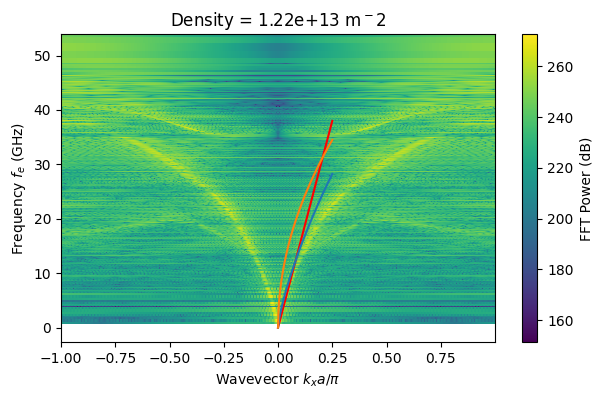

In [139]:
plot_fourier_transforms(res['x'], efreqs, evecs)

channel_depth = 0.5e-6
channel_width = 0.0e-6

n_s = density_from_positions(final_x, final_y)
a = mean_electron_spacing(final_x, final_y)
k = np.linspace(0, .25 * np.pi / a, 100)

f_theory = np.sqrt(n_s * qe ** 2 * k ** 2 * channel_depth / (2 * eps0 * me)) / (2 * np.pi)
plt.plot(k * a / np.pi, f_theory/1e9, '-r', label="Theory")

plt.title(fr"Density = {n_s:.2e} m$^{-2}$")

for channel_depth in [0.2e-6, 100e-6]:
    F_x = np.tanh(k * channel_depth) + np.tanh(k * channel_width)
    f_theory = np.sqrt(n_s * qe ** 2 * np.sqrt(k ** 2 * F_x) / (2 * eps0 * me)) / (2 * np.pi)
    plt.plot(k * a / np.pi, f_theory / 1e9)

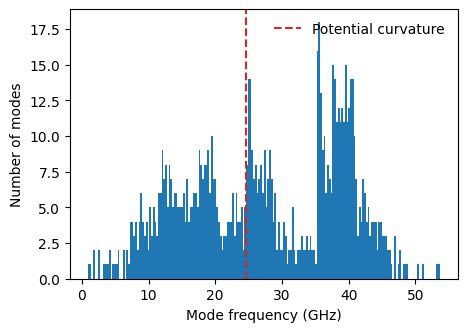

In [140]:
trap_curvature = 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['trench'] * quadratic_coefficient / me)

fig = plt.figure(figsize=(5., 3.5))
plt.hist(efreqs/1e9, bins=200)
plt.axvline(trap_curvature, linestyle='--', color='tab:red', label="Potential curvature")
plt.xlabel("Mode frequency (GHz)")
plt.ylabel(f"Number of modes")

plt.legend(loc=0, frameon=False)

In [141]:
chain_length = np.max(final_x) - np.min(final_x)
k = np.pi / chain_length

w_e = 2 * np.max(final_y)
channel_depth = 1e-6

F_x = 1 #np.tanh(k * (channel_width - w_e)) + np.tanh(k * channel_depth)

f_theory = np.sqrt(n_s * qe ** 2 * np.sqrt(k ** 2 * F_x) / (2 * eps0 * me)) / (2 * np.pi)

print(f_theory / 1e9)

5.674192927094494


In [142]:
f_theory = np.sqrt(n_s * qe ** 2 * k ** 2 * channel_depth / (2 * eps0 * me)) / (2 * np.pi)
print(f_theory / 1e9)


1.454419114183316
